In [41]:
# Cell 1: imports and model setup
from typing import List, Any, Dict, Annotated, TypedDict, Optional
from operator import add
from pydantic import BaseModel, HttpUrl, ValidationError
import os, json, time
from urllib.parse import urlparse, parse_qs, urlunparse
import shutil

In [42]:
# external libs (these do the real work inside nodes)
from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled, NoTranscriptFound
from pytube import Playlist
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
# from langchain_community.vectorstores import Chroma
from langchain_chroma import Chroma
from sentence_transformers import CrossEncoder
from langchain_ollama.chat_models import ChatOllama
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, START, END, add_messages, MessagesState
from langchain_core.documents import Document

In [43]:
# LLM client (adjust if your Ollama endpoint differs)
llm = ChatOllama(model="llama3.1:latest", base_url="http://localhost:11434", reasoning=False, streaming=False, request_timeout=600.0)
# Cross-encoder for rerank
cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-12-v2")

In [44]:
# languages you care about
COMMON_LANGUAGES = ['en', 'hi', 'es', 'zh-Hans', 'ar', 'fr', 'ru', 'pt', 'bn', 'de']

In [45]:
# ==========================================================
# 🧠 Cell 2 — State schema
# ==========================================================
class VideoRAGState(TypedDict):
    video_url: str
    query: str
    video_id: str
    transcripts: Dict[str, List[Dict[str, Any]]]
    docs_with_meta: List[Dict[str, Any]]
    chunks: List[Any]
    unique_chunks: List[Any]
    vector_store: Optional[Any]
    retriever: Optional[Any]
    retrieved_docs: List[Any]
    reranked_docs: List[Any]
    context_text: str
    answer: str


In [46]:
# ==========================================================
# 🧾 Utility: more robust YouTube URL cleaning (handles youtu.be)
# ==========================================================
def clean_video_url(video_url: str):
    """
    Returns (cleaned_url, video_id).
    Handles both standard and short YouTube URLs.
    """
    parsed = urlparse(video_url)
    qs = parse_qs(parsed.query)

    # Standard watch?v=
    if 'v' in qs and qs['v']:
        vid = qs['v'][0]
        cleaned = parsed._replace(query=f"v={vid}")
        return urlunparse(cleaned), vid

    # Short youtu.be/<id>
    if parsed.netloc.endswith("youtu.be"):
        vid = parsed.path.lstrip("/")
        if vid:
            cleaned = parsed._replace(query=f"v={vid}")
            return urlunparse(cleaned), vid

    raise ValueError("Invalid YouTube URL: could not extract video ID")

In [47]:
# ==========================================================
# 🧾 Cell 3: transcript fetcher node (fixed)
# ==========================================================
def fetch_multilingual_transcripts_node(state: VideoRAGState):
    clean_url, vid = clean_video_url(state["video_url"])
    transcripts_data = {}

    os.makedirs("transcripts", exist_ok=True)
    for lang in COMMON_LANGUAGES:
        fpath = f"transcripts/{vid}_{lang}.json"
        if os.path.exists(fpath):
            with open(fpath, "r", encoding="utf-8") as f:
                transcripts_data[lang] = json.load(f)
            continue

        try:
            # Fixed: Use the correct API method
            api = YouTubeTranscriptApi()
            transcript_list = api.fetch(vid)
            try:
                transcript = transcript_list.find_transcript([lang])
                translated_transcript = transcript.translate(lang)
                tlist = translated_transcript.fetch()
            except:
                # Try to get any available transcript and translate
                try:
                    transcript = transcript_list.find_transcript(['en'])
                    translated_transcript = transcript.translate(lang)
                    tlist = translated_transcript.fetch()
                except:
                    continue

            structured = [
                {"start": s["start"], "duration": s.get("duration", 0), "text": s["text"].strip()}
                for s in tlist
            ]
            transcripts_data[lang] = structured
            with open(fpath, "w", encoding="utf-8") as f:
                json.dump(structured, f, ensure_ascii=False, indent=2)
        except Exception as e:
            print(f"Error fetching {lang} transcript:", e)
            continue

    print("Fetched languages:", list(transcripts_data.keys()))
    return {"video_id": vid, "transcripts": transcripts_data}

In [48]:
def debug_transcript_quality(state: VideoRAGState):
    """Debug function to check transcript quality"""
    print("\n🔍 DEBUG TRANSCRIPT QUALITY:")
    total_snippets = 0
    total_chars = 0
    
    for lang, snippets in state["transcripts"].items():
        print(f"  {lang}: {len(snippets)} snippets")
        total_snippets += len(snippets)
        for snippet in snippets[:3]:  # Show first 3 snippets
            text = snippet["text"].strip()
            total_chars += len(text)
            print(f"    - '{text[:50]}{'...' if len(text) > 50 else ''}'")
    
    print(f"📊 Total: {total_snippets} snippets, ~{total_chars} characters")
    
    # Check if we have substantial content
    if total_chars < 500:
        print("❌ WARNING: Very little transcript content available!")
    elif total_chars < 2000:
        print("⚠️  WARNING: Limited transcript content available")

# Call this after fetch_multilingual_transcripts_node

In [49]:
# ==========================================================
# 🧩 Cell 4 — Build docs with metadata (FIXED: Proper timestamp calculation)
# ==========================================================
def build_docs_with_meta_node(state: VideoRAGState):
    docs = []
    for lang, snippets in state["transcripts"].items():
        for i, sn in enumerate(snippets):
            # Calculate end_time properly - use next snippet's start time if available
            if i + 1 < len(snippets):
                end_time = snippets[i + 1]["start"]
            else:
                end_time = sn["start"] + max(sn.get("duration", 10), 10)  # min 10 sec
            
            meta = {
                "video_id": state["video_id"],
                "language": lang,
                "start_time": sn["start"],
                "end_time": end_time,
                "text_length": len(sn["text"].strip())
            }
            # Only include meaningful content (not empty or too short)
            if sn["text"].strip() and len(sn["text"].strip()) > 5:
                docs.append({"text": sn["text"].strip(), "metadata": meta})
    
    print(f"✅ Prepared {len(docs)} docs_with_meta (filtered from {sum(len(s) for s in state['transcripts'].values())} total snippets)")
    return {"docs_with_meta": docs}

In [50]:
# ==========================================================
# ✂️ Cell 5 — Split into chunks (IMPROVED: Better chunking strategy)
# ==========================================================
def split_into_chunks_node(state: VideoRAGState):
    # Use larger chunks for better context
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=800,  # Increased from 500
        chunk_overlap=150,  # Increased from 100
        separators=["\n\n", "\n", ".", "!", "?", "।", "؟", "。", "！", "？"]
    )
    
    all_chunks = []
    for doc in state["docs_with_meta"]:
        if len(doc["text"]) > 50:  # Only split substantial text
            doc_obj = Document(page_content=doc["text"], metadata=doc["metadata"])
            split_docs = splitter.split_documents([doc_obj])
            all_chunks.extend(split_docs)
        else:
            # Keep short docs as-is
            all_chunks.append(Document(page_content=doc["text"], metadata=doc["metadata"]))

    # Better deduplication
    seen_content = set()
    unique_chunks = []
    
    for chunk in all_chunks:
        # Normalize text for deduplication
        normalized = ' '.join(chunk.page_content.strip().split())
        if normalized and len(normalized) > 10 and normalized not in seen_content:
            seen_content.add(normalized)
            unique_chunks.append(chunk)

    # Convert to dict format for state
    chunk_dicts = [
        {"text": c.page_content, "metadata": c.metadata}
        for c in all_chunks
    ]
    unique_dicts = [
        {"text": c.page_content, "metadata": c.metadata}
        for c in unique_chunks
    ]

    print(f"✅ Chunks: {len(chunk_dicts)}, Unique: {len(unique_dicts)}")
    return {"chunks": chunk_dicts, "unique_chunks": unique_dicts}

In [51]:
# ==========================================================
# 🧠 Cell 6 — Build or load vector store (FIXED: Proper Chroma usage)
# ==========================================================
def build_vector_store_node(state: VideoRAGState):
    vid = state["video_id"]
    db_dir = f"chroma_db/{vid}"
    os.makedirs("chroma_db", exist_ok=True)

    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/distiluse-base-multilingual-cased-v2",
        model_kwargs={"trust_remote_code": True},
    )

    texts = [c["text"] for c in state["unique_chunks"]]
    metadatas = [c["metadata"] for c in state["unique_chunks"]]

    if os.path.exists(db_dir) and os.listdir(db_dir):
        print(f"✅ Using cached vector store for {vid}")
        vectordb = Chroma(persist_directory=db_dir, embedding_function=embeddings)
    else:
        print(f"🚀 Creating new vector store for {vid}")
        vectordb = Chroma.from_texts(
            texts=texts,
            embedding=embeddings,
            metadatas=metadatas,
            persist_directory=db_dir,
        )

    retriever = vectordb.as_retriever(search_type="similarity", search_kwargs={"k": 10})
    return {"vector_store": vectordb, "retriever": retriever}

In [52]:
def debug_retrieval(state: VideoRAGState):
    """Debug retrieval to see what's actually being found"""
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/distiluse-base-multilingual-cased-v2",
        model_kwargs={"trust_remote_code": True},
    )
    
    vectordb = Chroma(
        persist_directory=f"chroma_db/{state['video_id']}", 
        embedding_function=embeddings
    )
    
    # Use the same retriever configuration as in retrieve_node
    retriever = vectordb.as_retriever(
        search_type="mmr",
        search_kwargs={
            "k": 20,
            "fetch_k": 20,
            "lambda_mult": 0.7
        }
    )
    
    test_docs = retriever.invoke(state["query"])
    print(f"\n🔍 DEBUG RETRIEVAL for query: '{state['query']}'")
    for i, doc in enumerate(test_docs):
        print(f"  Doc {i+1}: '{doc.page_content[:100]}...'")
    
    return test_docs

In [53]:
# ==========================================================
# 🔍 Cell 7 — Retrieve (IMPROVED: Better search parameters)
# ==========================================================
def retrieve_node(state: VideoRAGState):
    try:
        embeddings = HuggingFaceEmbeddings(
            model_name="sentence-transformers/distiluse-base-multilingual-cased-v2",
            model_kwargs={"trust_remote_code": True},
        )
        
        # Load vector store
        vectordb = Chroma(
            persist_directory=f"chroma_db/{state['video_id']}", 
            embedding_function=embeddings
        )
        
        # Try simpler retrieval first
        retriever = vectordb.as_retriever(
            search_type="similarity",  # Use simple similarity first
            search_kwargs={
                "k": 20,  # Get more documents
            }
        )

        docs = retriever.invoke(state["query"])
        print(f"✅ Retrieved {len(docs)} documents")
        
        # Filter out very short documents but be less strict
        filtered_docs = []
        for doc in docs:
            content = doc.page_content.strip()
            if len(content) > 10:  # Reduced from 20
                filtered_docs.append(doc)
        
        print(f"✅ Filtered to {len(filtered_docs)} documents")
        
        # Convert to dict format
        docs_dict = [{"text": d.page_content, "metadata": d.metadata} for d in filtered_docs]
        return {"retrieved_docs": docs_dict}
        
    except Exception as e:
        print(f"❌ Error in retrieval: {e}")
        return {"retrieved_docs": []}

In [54]:
# ==========================================================
# 📊 Cell 8 — Rerank (FIXED: Proper threshold for cross-encoder)
# ==========================================================
def rerank_node(state: VideoRAGState, top_n=7):
    docs = state["retrieved_docs"]
    if not docs:
        print("❌ No documents to rerank")
        return {"reranked_docs": []}

    # Create query-document pairs
    pairs = [[state["query"], d["text"]] for d in docs]
    
    # Get scores from cross-encoder
    scores = cross_encoder.predict(pairs)
    
    # For this cross-encoder model, scores can be negative
    # Use a more appropriate threshold or just take top N regardless
    scored_docs = list(zip(scores, docs))
    
    # Sort by score (highest first)
    scored_docs.sort(key=lambda x: x[0], reverse=True)
    
    # Take top N without threshold, or use a very low threshold
    top_docs = [doc for score, doc in scored_docs[:top_n]]
    
    print(f"✅ Reranked: {len(top_docs)} docs (top {top_n})")
    print(f"📊 Score range: {min(scores):.3f} - {max(scores):.3f}")
    print(f"📈 Top score: {scored_docs[0][0]:.3f}" if scored_docs else "No scores")
    
    return {"reranked_docs": top_docs}

In [55]:
# ==========================================================
# 🧱 Cell 9 — Format context (FIXED: Handle low-score results)
# ==========================================================
def format_context_node(state: VideoRAGState):
    if not state["reranked_docs"]:
        print("⚠️ No high-scoring docs, but let's use what we have")
        # If reranking filtered everything out, use the original retrieved docs
        if "retrieved_docs" in state and state["retrieved_docs"]:
            print("🔄 Falling back to original retrieved docs")
            docs_to_use = state["retrieved_docs"][:5]  # Use top 5 original docs
        else:
            return {"context_text": "No relevant information found in the video."}

    else:
        docs_to_use = state["reranked_docs"]

    def seconds_to_timestamp(seconds):
        """Convert seconds to MM:SS format"""
        minutes = int(seconds // 60)
        secs = int(seconds % 60)
        return f"{minutes:02d}:{secs:02d}"

    context_parts = []
    for i, d in enumerate(docs_to_use):
        start_time = d['metadata'].get('start_time', 0)
        end_time = d['metadata'].get('end_time', start_time + 10)
        
        time_range = f"{seconds_to_timestamp(start_time)}-{seconds_to_timestamp(end_time)}"
        context_parts.append(f"Segment {i+1} [{time_range}]: {d['text']}")
    
    context_text = "\n\n".join(context_parts)
    print(f"✅ Formatted context with {len(context_parts)} segments")
    return {"context_text": context_text}

In [56]:
# ==========================================================
# 📝 Cell 10 — Summarize full video (IMPROVED: Better content handling)
# ==========================================================
def summarize_video_node(state: VideoRAGState, max_chars=25000):
    if not state["unique_chunks"]:
        return {"answer": "No content available for summarization."}
    
    # Use all unique chunks for summary
    all_text = " ".join([c["text"] for c in state["unique_chunks"]])[:max_chars]
    
    if len(all_text.strip()) < 100:
        return {"answer": "Not enough transcript content available for a meaningful summary."}
    
    prompt_text = f"""
You are an expert video summarizer. Create a comprehensive summary of the following YouTube transcript.

TRANSCRIPT CONTENT:
{all_text}

INSTRUCTIONS:
- Create a detailed, well-structured summary
- Capture the main themes and key points
- Maintain the original meaning and context
- Write in clear, natural language

SUMMARY:
"""
    try:
        resp = llm.invoke(prompt_text)
        print("✅ Full video summary generated")
        return {"answer": resp.content}
    except Exception as e:
        print(f"❌ Error in summarization: {e}")
        return {"answer": "Error generating summary."}

In [57]:
# ==========================================================
# 💬 Cell 11 — LLM answer node (FIXED: Proper prompt handling)
# ==========================================================
def llm_answer_node(state: VideoRAGState):
    query = state["query"].lower()
    
    # If we have very little context, be upfront about it
    if "No relevant information" in state["context_text"] or len(state["context_text"]) < 100:
        return {"answer": "I couldn't find specific information in the video that directly answers your question. The transcript content may not cover this topic, or the retrieval didn't find relevant matches."}
    
    # Detect if this is a timing-related question
    time_keywords = [
        "when", "time", "timestamp", "at what time", "minute", "second", 
        "hour", "duration", "start", "end", "begin", "moment", "point in time",
        "how long", "what time", "which part", "where in the video", "at which"
    ]
    
    include_timestamps = any(keyword in query for keyword in time_keywords)
    
    if include_timestamps:
        prompt_template = """Based on the video content below, answer the user's question focusing on timing information:

CONTEXT:
{context_text}

QUESTION: {query}

Answer with specific timestamps when possible. If exact timing isn't available, provide the best estimate based on the context.
"""
    else:
        prompt_template = """Based on the video content below, answer the user's question:

CONTEXT:
{context_text}

QUESTION: {query}

Provide a helpful answer using the available context. If the context doesn't fully address the question, acknowledge this limitation.
"""

    # Create prompt inside the function
    prompt = PromptTemplate(
        input_variables=["context_text", "query"],
        template=prompt_template
    )
    
    try:
        chain = prompt | llm | StrOutputParser()
        resp = chain.invoke({"context_text": state["context_text"], "query": state["query"]})
        print("✅ LLM answer generated")
        return {"answer": resp}
    except Exception as e:
        print(f"❌ Error in LLM: {e}")
        return {"answer": "I encountered an error while processing your question. Please try again with a different query."}

In [58]:
# ==========================================================
# 🎯 Router function to decide summary vs Q&A
# ==========================================================
def route_question(state: VideoRAGState):
    """Route to summary or Q&A based on query"""
    query = state["query"].lower().strip()
    if query == "summarize" or "summary" in query:
        return "summarize"
    else:
        return "retrieve"

In [59]:
# ==========================================================
# 🔗 Cell 12 — Build graph (FIXED: Proper routing)
# ==========================================================
graph = StateGraph(VideoRAGState)

graph.add_node("fetch_transcripts", fetch_multilingual_transcripts_node)
graph.add_node("build_docs", build_docs_with_meta_node)
graph.add_node("split", split_into_chunks_node)
graph.add_node("vectorize", build_vector_store_node)
graph.add_node("retrieve", retrieve_node)
graph.add_node("rerank", rerank_node)
graph.add_node("format", format_context_node)
graph.add_node("answer", llm_answer_node)
graph.add_node("summarize", summarize_video_node)

graph.add_edge(START, "fetch_transcripts")
graph.add_edge("fetch_transcripts", "build_docs")
graph.add_edge("build_docs", "split")
graph.add_edge("split", "vectorize")

# Add conditional routing after vectorize
graph.add_conditional_edges(
    "vectorize",
    route_question,
    {
        "summarize": "summarize",
        "retrieve": "retrieve",
    }
)

graph.add_edge("retrieve", "rerank")
graph.add_edge("rerank", "format")
graph.add_edge("format", "answer")
graph.add_edge("summarize", END)
graph.add_edge("answer", END)

app = graph.compile()
print("✅ Graph compiled successfully!")

✅ Graph compiled successfully!


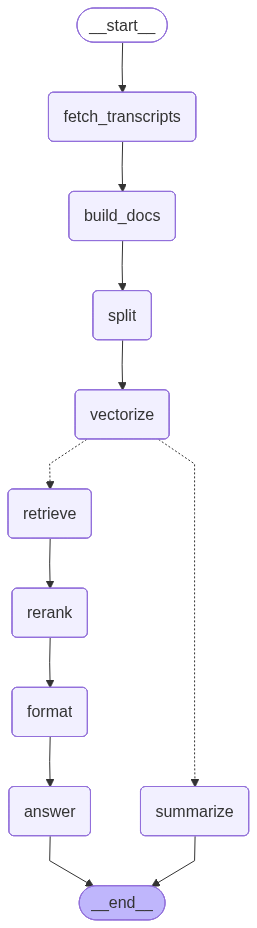

In [64]:
from IPython.display import Image, display
image_data = app.get_graph().draw_mermaid_png()
display(Image(image_data))


In [60]:
# ==========================================================
# 🚀 Runner (FIXED: Proper state initialization)
# ==========================================================
if __name__ == "__main__":
    # Gather inputs once (avoid double prompt)
    video_url = input("Enter YouTube URL: ").strip()
    query = input("Enter your question: ").strip()

    # Build initial TypedDict state
    state: VideoRAGState = {
        "video_url": video_url,
        "query": query,
        "video_id": "",
        "transcripts": {},
        "docs_with_meta": [],
        "chunks": [],
        "unique_chunks": [],
        "vector_store": None,
        "retriever": None,
        "retrieved_docs": [],
        "reranked_docs": [],
        "context_text": "",
        "answer": ""
    }

    try:

        # Run the compiled graph
        final_state = app.invoke(state)
    except Exception as e:
        print(f"❌ Error: {e}")
        print("Please check the YouTube URL and try again.")

Fetched languages: ['en']
✅ Prepared 1102 docs_with_meta (filtered from 1104 total snippets)
✅ Chunks: 1102, Unique: 1096
✅ Using cached vector store for bdpyQm5l78o
✅ Retrieved 20 documents
✅ Filtered to 20 documents
✅ Reranked: 7 docs (top 7)
📊 Score range: -11.306 - -7.913
📈 Top score: -7.913
✅ Formatted context with 7 segments
✅ LLM answer generated


In [62]:
print("\n🎯 Final Answer:\n", final_state["answer"])


🎯 Final Answer:
 Based on the provided segments of the video, it's difficult to provide a comprehensive summary without seeing more context or content from the full video. However, I can attempt to piece together some information based on the given snippets.

The video seems to touch on various themes related to understanding and empathy, including:

- The importance of "opening up your heart" to understanding others (Segment 3)
- Emphasizing that one should understand the other side (Segment 4)
- A story or anecdote is mentioned in a lighthearted manner (Segments 7 and possibly Segment 2, suggesting a narrative approach to storytelling), which might be used for illustrative purposes.
  
Without more content from the video, it's hard to determine what specific topics are covered or how they relate to each other. The themes of understanding, empathy, and perhaps communication strategies through storytelling are hinted at but require more context to fully understand their implications i